In [154]:
import pandas as pd
import geopandas as gpd #allows for world map overlay
from shapely.geometry import Polygon

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors

import tkinter as tk
from tkinter import simpledialog, messagebox

import fsspec
from datetime import datetime
from shapely.geometry import box

In [12]:
# -------------------------------------------------------------------
# World Map Overlay
# -------------------------------------------------------------------
# Function to plot world map outline

url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/110m_cultural.zip"

def plot_world_map(ax):    
    with fsspec.open(f"simplecache::{url}") as file:
        world = gpd.read_file(file)
    #world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

In [ ]:
def calculate_intersection_areas(grid_gdf, gdf):
    for cell in grid_gdf.itertuples():
        # Initialize the count to 0 for each cell
        grid_gdf.at[cell.Index, 'count'] = 0
        for poly in gdf['geometry']:
            if cell.geometry.intersects(poly):
                # Calculate the intersection area
                intersection_area = cell.geometry.intersection(poly).area
                # Aggregate the intersection areas
                grid_gdf.at[cell.Index, 'count'] += intersection_area
    return grid_gdf

In [17]:
%%time
df = pd.read_csv('coordinates_dates_2022.csv')
df['geometry'] = df.apply(lambda row: Polygon([
    (row['coordinate1_lon'], row['coordinate1_lat']),
    (row['coordinate2_lon'], row['coordinate2_lat']),
    (row['coordinate3_lon'], row['coordinate3_lat']),
    (row['coordinate4_lon'], row['coordinate4_lat']),
    (row['coordinate5_lon'], row['coordinate5_lat']),
]), axis=1)


CPU times: total: 17.7 s
Wall time: 55.3 s


In [53]:
%%time
# Create a GeoDataFrame from the DataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

CPU times: total: 531 ms
Wall time: 1.88 s


In [115]:
df

,coordinate1_lat,coordinate1_lon,coordinate2_lat,coordinate2_lon,coordinate3_lat,coordinate3_lon,coordinate4_lat,coordinate4_lon,coordinate5_lat,coordinate5_lon,start date,geometry
0,-76.563416,-44.430351,-75.814583,-46.127155,-72.724609,-45.382088,-73.559357,-43.706284,-76.563416,-44.430351,2022-12-31T23:58:02.000Z,"POLYGON ((-44.430351 -76.563416, -46.127155 -7..."
1,-75.850296,-45.997704,-75.114128,-47.577160,-71.954697,-46.814419,-72.776138,-45.255939,-75.850296,-45.997704,2022-12-31T23:57:37.000Z,"POLYGON ((-45.997704 -75.850296, -47.57716 -75..."
2,-75.175659,-47.453228,-74.400711,-49.027828,-71.156517,-48.244160,-72.022278,-46.692039,-75.175659,-47.453228,2022-12-31T23:57:12.000Z,"POLYGON ((-47.453228 -75.175659, -49.027828 -7..."
3,-74.468964,-48.904789,-73.650627,-50.475075,-70.314629,-49.668659,-71.229767,-48.122524,-74.468964,-48.904789,2022-12-31T23:56:47.000Z,"POLYGON ((-48.904789 -74.468964, -50.475075 -7..."
4,-73.724197,-50.352829,-72.826584,-51.972496,-69.388390,-51.140526,-70.392876,-49.547813,-73.724197,-50.352829,2022-12-31T23:56:22.000Z,"POLYGON ((-50.352829 -73.724197, -51.972496 -7..."
...,...,...,...,...,...,...,...,...,...,...,...,...
194011,-90.437431,16.703709,-90.100838,15.074732,-87.776344,15.513787,-88.092934,17.138910,-90.437431,16.703709,2022-01-01T00:06:42.000Z,"POLYGON ((16.703709 -90.437431, 15.074732 -90...."
194012,-90.117363,15.204923,-89.781845,13.575911,-87.477913,14.017756,-87.795578,15.642788,-90.117363,15.204923,2022-01-01T00:06:17.000Z,"POLYGON ((15.204923 -90.117363, 13.575911 -89...."
194013,-89.816216,13.702367,-89.481239,12.072970,-87.188438,12.519310,-87.507591,14.144605,-89.816216,13.702367,2022-01-01T00:05:52.000Z,"POLYGON ((13.702367 -89.816216, 12.07297 -89.4..."
194014,-89.509468,12.201158,-89.163139,10.514731,-86.882675,10.965281,-87.214729,12.647332,-89.509468,12.201158,2022-01-01T00:05:26.000Z,"POLYGON ((12.201158 -89.509468, 10.514731 -89...."


In [58]:
gdf

,coordinate1_lat,coordinate1_lon,coordinate2_lat,coordinate2_lon,coordinate3_lat,coordinate3_lon,coordinate4_lat,coordinate4_lon,coordinate5_lat,coordinate5_lon,start date,geometry
0,-76.563416,-44.430351,-75.814583,-46.127155,-72.724609,-45.382088,-73.559357,-43.706284,-76.563416,-44.430351,2022-12-31T23:58:02.000Z,"POLYGON ((-44.430 -76.563, -46.127 -75.815, -4..."
1,-75.850296,-45.997704,-75.114128,-47.577160,-71.954697,-46.814419,-72.776138,-45.255939,-75.850296,-45.997704,2022-12-31T23:57:37.000Z,"POLYGON ((-45.998 -75.850, -47.577 -75.114, -4..."
2,-75.175659,-47.453228,-74.400711,-49.027828,-71.156517,-48.244160,-72.022278,-46.692039,-75.175659,-47.453228,2022-12-31T23:57:12.000Z,"POLYGON ((-47.453 -75.176, -49.028 -74.401, -4..."
3,-74.468964,-48.904789,-73.650627,-50.475075,-70.314629,-49.668659,-71.229767,-48.122524,-74.468964,-48.904789,2022-12-31T23:56:47.000Z,"POLYGON ((-48.905 -74.469, -50.475 -73.651, -4..."
4,-73.724197,-50.352829,-72.826584,-51.972496,-69.388390,-51.140526,-70.392876,-49.547813,-73.724197,-50.352829,2022-12-31T23:56:22.000Z,"POLYGON ((-50.353 -73.724, -51.972 -72.827, -5..."
...,...,...,...,...,...,...,...,...,...,...,...,...
194011,-90.437431,16.703709,-90.100838,15.074732,-87.776344,15.513787,-88.092934,17.138910,-90.437431,16.703709,2022-01-01T00:06:42.000Z,"POLYGON ((16.704 -90.437, 15.075 -90.101, 15.5..."
194012,-90.117363,15.204923,-89.781845,13.575911,-87.477913,14.017756,-87.795578,15.642788,-90.117363,15.204923,2022-01-01T00:06:17.000Z,"POLYGON ((15.205 -90.117, 13.576 -89.782, 14.0..."
194013,-89.816216,13.702367,-89.481239,12.072970,-87.188438,12.519310,-87.507591,14.144605,-89.816216,13.702367,2022-01-01T00:05:52.000Z,"POLYGON ((13.702 -89.816, 12.073 -89.481, 12.5..."
194014,-89.509468,12.201158,-89.163139,10.514731,-86.882675,10.965281,-87.214729,12.647332,-89.509468,12.201158,2022-01-01T00:05:26.000Z,"POLYGON ((12.201 -89.509, 10.515 -89.163, 10.9..."


In [102]:
%%time
minx, miny, maxx, maxy = gdf.total_bounds
width = maxx - minx
height = maxy - miny

# Define the number of divisions in the grid
divisions = 150

CPU times: total: 46.9 ms
Wall time: 64.1 ms


In [103]:
%%time
# Initialize an empty list to hold the data dictionaries
full_year_data_list = []

# Populate the list with counts
for i in range(divisions):
    for j in range(divisions):
        # Define the corners of the grid cell
        cell_minx = minx + i * (width / divisions)
        cell_miny = miny + j * (height / divisions)
        cell_maxx = minx + (i + 1) * (width / divisions)
        cell_maxy = miny + (j + 1) * (height / divisions)
        cell = Polygon([(cell_minx, cell_miny), (cell_maxx, cell_miny), (cell_maxx, cell_maxy), (cell_minx, cell_maxy)])
        count = gdf[gdf.geometry.intersects(cell)].shape[0]
        full_year_data_list.append({'geometry': cell, 'count': count})

CPU times: total: 7min 36s
Wall time: 19min 18s


In [106]:
%%time
# Convert the list of dictionaries to a GeoDataFrame
heatmap_gdf = gpd.GeoDataFrame(full_year_data_list)


CPU times: total: 109 ms
Wall time: 223 ms


In [107]:
heatmap_gdf

,geometry,count
0,"POLYGON ((-78.665 -179.950, -77.558 -179.950, ...",0
1,"POLYGON ((-78.665 -177.551, -77.558 -177.551, ...",0
2,"POLYGON ((-78.665 -175.152, -77.558 -175.152, ...",0
3,"POLYGON ((-78.665 -172.753, -77.558 -172.753, ...",0
4,"POLYGON ((-78.665 -170.354, -77.558 -170.354, ...",0
...,...,...
22495,"POLYGON ((86.276 167.936, 87.383 167.936, 87.3...",0
22496,"POLYGON ((86.276 170.336, 87.383 170.336, 87.3...",0
22497,"POLYGON ((86.276 172.735, 87.383 172.735, 87.3...",0
22498,"POLYGON ((86.276 175.134, 87.383 175.134, 87.3...",0


In [110]:
heatmap_gdf.to_csv('polygon_only_2022.csv', index=False)

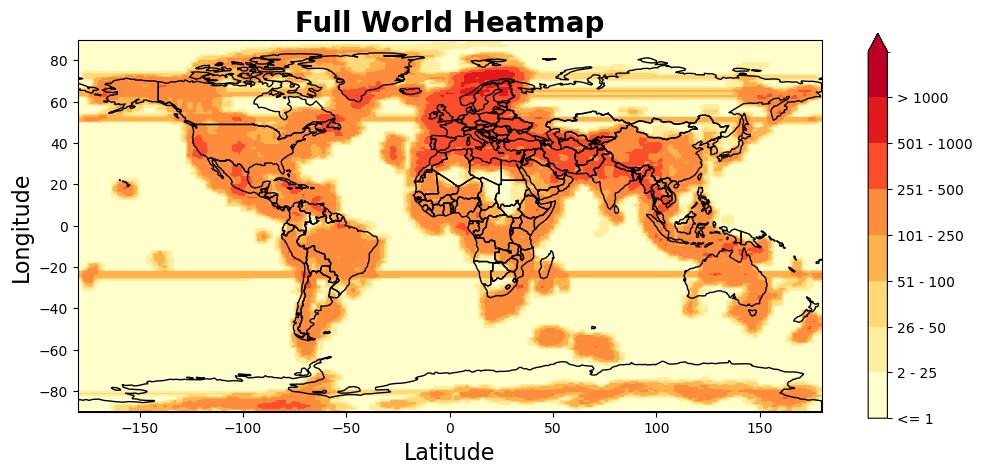

CPU times: total: 2.03 s
Wall time: 4.64 s


In [109]:
%%time
# Create a higher resolution 2D grid for the heatmap
# heatmap_grid = np.zeros((grid_size, grid_size))

# Normalize the grid for image intensity
# heatmap_grid_normalized = heatmap_grid / heatmap_grid.max()

# Rotate the data using NumPy
# rotated_heatmap = np.rot90(heatmap_grid_normalized)

# Define custom colors based on the number of data points
colors = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026']
cmap = ListedColormap(colors)

boundaries = [0, 1, 25, 50, 100, 250, 500, 1000, 3000]

# Create a BoundaryNorm for the colorbar
norm = BoundaryNorm(boundaries, len(colors), clip=True)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Overlay world map outline
plot_world_map(ax)

# Invert the heatmap data vertically
heatmap_data = np.flipud(heatmap_gdf['count'].values.reshape(divisions, divisions))

# Plot the heatmap with custom colors
heatmap = ax.imshow(heatmap_data, cmap=cmap, norm=norm, extent=[-180, 180, -90, 90])  

# Create the colorbar with discrete blocks
colorbar = plt.colorbar(heatmap, boundaries=boundaries[:-1], ticks=boundaries[:-1], extend='max', shrink=0.5)

# Set the colorbar labels
colorbar_labels = ['<= 1', '2 - 25', '26 - 50', '51 - 100', '101 - 250', '251 - 500', '501 - 1000', '> 1000']
colorbar.ax.set_yticklabels(colorbar_labels)
# Set the title and labels
ax.set_title("Full World Heatmap", fontsize=20, fontweight='bold')
ax.set_xlabel("Latitude", fontsize=16)
ax.set_ylabel("Longitude", fontsize=16)

# Save and show the image
plt.savefig('heatmap_with_world_map.png')
plt.show()
#display_heatmap()
#root.destroy()

In [185]:
# -------------------------------------------------------------------
# Heatmap Functions
# -------------------------------------------------------------------
# Heatmap() function for generating custom-colored heatmaps
#this is for the custom heatmaps
def Heatmaps(start_date, end_date, min_lat, max_lat, min_lon, max_lon):
    # Convert user input to datetime strings
    start_date_str = start_date + 'T00:00:00.000Z'
    end_date_str = end_date + 'T23:59:59.999Z'

    # Filter data based on user-provided latitude and longitude range
    filtered_df = df[(df['coordinate1_lat'] >= min_lat) & (df['coordinate1_lat'] <= max_lat) &
                     (df['coordinate1_lon'] >= min_lon) & (df['coordinate1_lon'] <= max_lon)]
    # Filter the DataFrame based on date range
    filtered_df = filtered_df[(filtered_df['start date'] >= start_date_str) & (filtered_df['start date'] <= end_date_str)]
    
    # Create a GeoDataFrame from the DataFrame
    gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')
    
    # Initialize an empty list to hold the data dictionaries
    custom_data_list = []

    # Populate the list with counts
    for i in range(divisions):
        for j in range(divisions):
            # Define the corners of the grid cell
            cell_minx = minx + i * (width / divisions)
            cell_miny = miny + j * (height / divisions)
            cell_maxx = minx + (i + 1) * (width / divisions)
            cell_maxy = miny + (j + 1) * (height / divisions)
            cell = Polygon([(cell_minx, cell_miny), (cell_maxx, cell_miny), (cell_maxx, cell_maxy), (cell_minx, cell_maxy)])
            count = gdf[gdf.geometry.intersects(cell)].shape[0]
            custom_data_list.append({'geometry': cell, 'count': count})

    # Convert the list of dictionaries to a DataFrame
    custom_data_df = pd.DataFrame(custom_data_list)
    
    # Define custom colors based on the number of data points
    colors = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026']
    cmap = ListedColormap(colors)

    boundaries = [0, 1, 25, 50, 100, 250, 500, 1000, 3000]

    # Create a BoundaryNorm for the colorbar
    norm = BoundaryNorm(boundaries, len(colors), clip=True)

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(12, 10))

    # Overlay world map outline
    plot_world_map(ax)

    # Invert the heatmap data vertically
    heatmap_data = np.flipud(custom_data_df['count'].values.reshape(divisions, divisions))

    # Plot the heatmap with custom colors
    heatmap = ax.imshow(heatmap_data, cmap=cmap, norm=norm, extent=[-180, 180, -90, 90])  

    # Create the colorbar with discrete blocks
    colorbar = plt.colorbar(heatmap, boundaries=boundaries[:-1], ticks=boundaries[:-1], extend='max', shrink=0.5)

    # Set the colorbar labels
    colorbar_labels = ['<= 1', '2 - 25', '26 - 50', '51 - 100', '101 - 250', '251 - 500', '501 - 1000', '> 1000']
    colorbar.ax.set_yticklabels(colorbar_labels)

    # Manually set up the axis range because the extent in heatmap was not working properly to show this range
    ax.set_xlim(min_lat, max_lat)
    ax.set_ylim(min_lon, max_lon)

    # Set axis labels
    ax.set_title('Requested Heatmap', fontsize=20, fontweight='bold')
    ax.set_xlabel('Longitude', fontsize=16)
    ax.set_ylabel('Latitude', fontsize=16)
    
    # Add gridlines to the heatmap
    ax.grid(which='both', linestyle='--', linewidth=0.5, color='gray')

    # Save and show the image
    plt.savefig('heatmap_with_world_map_specific_date_coords.png')
    plt.show()
    #display_heatmap()
    #root.destroy()

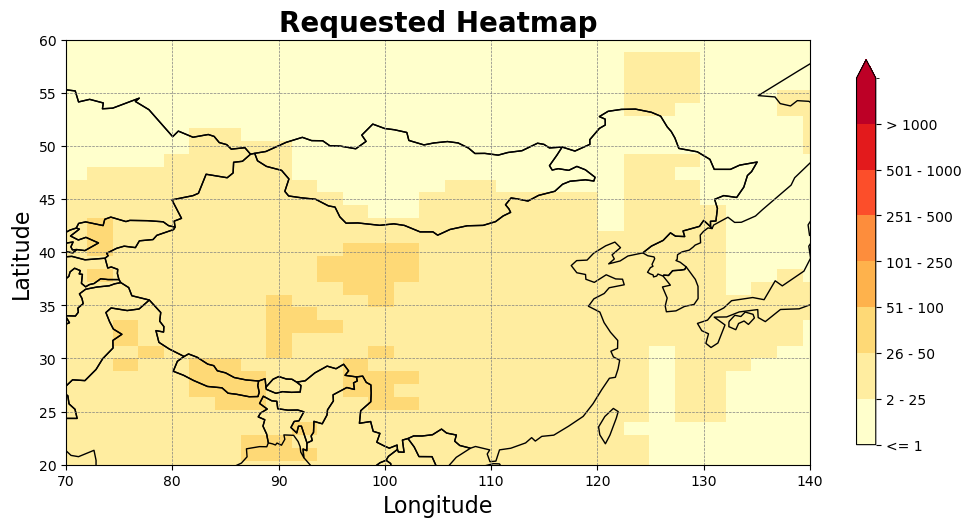

CPU times: total: 24.4 s
Wall time: 1min 30s


In [186]:
%%time
Heatmaps("2022-01-01", "2022-01-30", 70, 140, 20, 60)

In [129]:
# Function to handle the Generate Heatmap Using Date Range
def date_generate_heatmap(start_date, end_date):
    # Convert user input to datetime strings
    start_date_str = start_date + 'T00:00:00.000Z'
    end_date_str = end_date + 'T23:59:59.999Z'

    # Filter the DataFrame based on date range
    filtered_df = df[(df['start date'] >= start_date_str) & (df['start date'] <= end_date_str)]
    
    # Create a GeoDataFrame from the DataFrame
    gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')
    
    # Initialize an empty list to hold the data dictionaries
    custom_data_list = []

    # Populate the list with counts
    for i in range(divisions):
        for j in range(divisions):
            # Define the corners of the grid cell
            cell_minx = minx + i * (width / divisions)
            cell_miny = miny + j * (height / divisions)
            cell_maxx = minx + (i + 1) * (width / divisions)
            cell_maxy = miny + (j + 1) * (height / divisions)
            cell = Polygon([(cell_minx, cell_miny), (cell_maxx, cell_miny), (cell_maxx, cell_maxy), (cell_minx, cell_maxy)])
            count = gdf[gdf.geometry.intersects(cell)].shape[0]
            custom_data_list.append({'geometry': cell, 'count': count})
   
    # Convert the list of dictionaries to a DataFrame
    custom_data_df = pd.DataFrame(custom_data_list)
    
    # Define custom colors based on the number of data points
    colors = ['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026']
    cmap = ListedColormap(colors)

    boundaries = [0, 1, 25, 50, 100, 250, 500, 1000, 3000]

    # Create a BoundaryNorm for the colorbar
    norm = BoundaryNorm(boundaries, len(colors), clip=True)

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(12, 10))

    # Overlay world map outline
    plot_world_map(ax)

    # Invert the heatmap data vertically
    heatmap_data = np.flipud(custom_data_df['count'].values.reshape(divisions, divisions))

    # Plot the heatmap with custom colors
    heatmap = ax.imshow(heatmap_data, cmap=cmap, norm=norm, extent=[-180, 180, -90, 90])  

    # Create the colorbar with discrete blocks
    colorbar = plt.colorbar(heatmap, boundaries=boundaries[:-1], ticks=boundaries[:-1], extend='max', shrink=0.5)

    # Set the colorbar labels
    colorbar_labels = ['<= 1', '2 - 25', '26 - 50', '51 - 100', '101 - 250', '251 - 500', '501 - 1000', '> 1000']
    colorbar.ax.set_yticklabels(colorbar_labels)

    # Set the title and labels
    ax.set_title("Requested World Heatmap", fontsize=20, fontweight='bold')
    ax.set_xlabel("Latitude", fontsize=16)
    ax.set_ylabel("Longitude", fontsize=16)

    # Save and show the image
    plt.savefig('heatmap_with_world_map_specific_date.png')
    plt.show()
    #display_heatmap()
    #root.destroy()

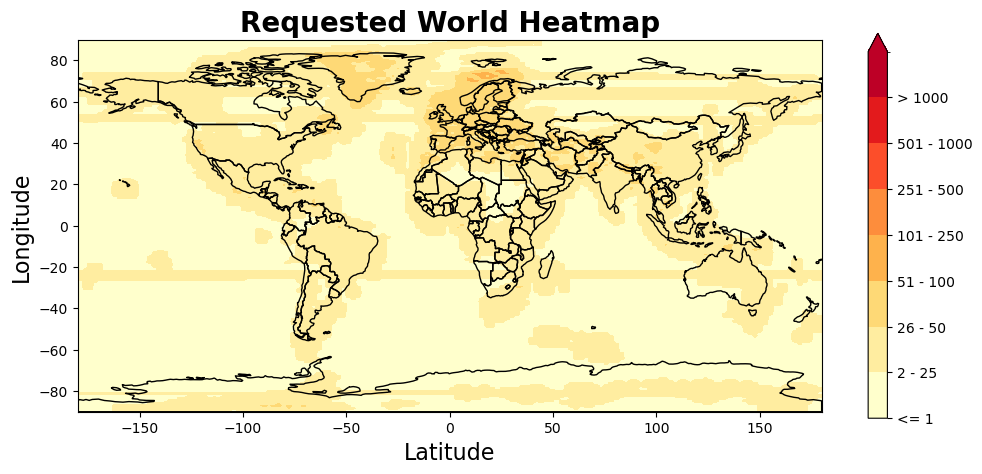

In [130]:
%%time
date_generate_heatmap("2022-01-01", "2022-01-30");

In [5]:
# -------------------------------------------------------------------
# Country Display function -- NEEDS WORK!
# -------------------------------------------------------------------

# Function to display a country on a world map
#this needs some adjustments and pieces so right now, it is listed as not implemented when hit on the dialog...
def display_country(country_name):
    with fsspec.open(f"simplecache::{url}") as file:
        world = gpd.read_file(file)
    #world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    country = world[world['name'] == country_name]

    fig, ax = plt.subplots(figsize=(10, 8))
    world.plot(ax=ax, color='lightgrey')
    country.plot(ax=ax, color='blue')

    ax.set_title(country_name)
    plt.show()


In [ ]:
# -------------------------------------------------------------------
# User Interfacing Functions - Button Implements
# -------------------------------------------------------------------
# Function to display the heatmap
def display_heatmap():
    plt.show(block=False)
    
# Function to handle the "Exit" button
def exit_program():
    root.destroy()  # Close the main window

# Function to handle the "Not Implemented" button
def not_implemented():
    messagebox.showinfo("Info", "This has yet to be implemented!")
    root.destroy()  # Close the main window

# -------------------------------------------------------------------
# User Infercaing Functions - Windows
# -------------------------------------------------------------------

# Function to create a custom dialog for selecting options
def choose_option_dialog():
    dialog = tk.Toplevel()
    dialog.title("ASF Heatmap Application")

    # Label
    label = tk.Label(dialog, text="Select an option:")
    label.pack(pady=10)

    # Button for Display Country on World Map
    btn_country = tk.Button(dialog, text="Display Country on World Map", command=not_implemented)
    btn_country.pack(pady=5) #lambda: display_country_dialog(dialog) is what was used in command above

    # Button for Generate Heatmap
    # btn_heatmap = tk.Button(dialog, text="Generate Custom Heatmap", command=lambda: generate_heatmap_dialog(dialog))
    # btn_heatmap.pack(pady=5)
    
    # Button for Generate Custom Heatmap Using Coordinates
    btn_coordinate_heatmap = tk.Button(dialog, text="Generate Custom Heatmap Using Coordinates", 
                                       command=lambda: generate_heatmap_dialog(dialog))
    btn_coordinate_heatmap.pack(pady=5)

    # Button for Generate Custom Heatmap Using Dates
    btn_date_heatmap = tk.Button(dialog, text="Generate Custom Heatmap Using Dates", 
                                 command=lambda: date_heatmap_dialog(dialog))
    btn_date_heatmap.pack(pady=5)

    # Button for Full World Heatmap
    btn_full_world_heatmap = tk.Button(dialog, text="Full World Heatmap", command=lambda: full_world_heatmap())
    btn_full_world_heatmap.pack(pady=5)

    # Button for "Exit"
    btn_exit = tk.Button(dialog, text="Exit", command=exit_program)
    btn_exit.pack(pady=5)

# -------------------------------------------------------------------
# User Interfacing Functions - Heatmap generation with UI
# -------------------------------------------------------------------

# Function to handle the Display Country on World Map option
def display_country_dialog(dialog):
    dialog.destroy()
    country_name = simpledialog.askstring("Input", "Enter the country name:")
    if country_name:
        display_country(country_name)
    else:
        messagebox.showinfo("Info", "Invalid country name.")

# Function to handle the Generate Heatmap Using Coordinates
def generate_heatmap_dialog(dialog):
    dialog.destroy()
    grid_size = simpledialog.askinteger("Input", "Enter the grid size for the heatmap (e.g., 150):")
    min_lat = simpledialog.askfloat("Input", "Enter the minimum latitude:")
    max_lat = simpledialog.askfloat("Input", "Enter the maximum latitude:")
    min_lon = simpledialog.askfloat("Input", "Enter the minimum longitude:")
    max_lon = simpledialog.askfloat("Input", "Enter the maximum longitude:")
    Heatmaps(grid_size, min_lat, max_lat, min_lon, max_lon)

# Function to handle the Generate Heatmap Using Dates
def date_heatmap_dialog(dialog):
    dialog.destroy()
    grid_size = simpledialog.askinteger("Input", "Enter the grid size for the heatmap (e.g., 150):")
    start_date_query = simpledialog.askstring("Input", "Enter the start date (YYYY-MM-DD):")
    end_date_query = simpledialog.askstring("Input", "Enter the end date (YYYY-MM-DD):")

    # Convert input strings to datetime objects
    start_date = datetime.strptime(start_date_query, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_query, '%Y-%m-%d')

    # Generate the heatmap using the filtered DataFrame
    date_generate_heatmap(grid_size, start_date, end_date)
